<a href="https://colab.research.google.com/github/YouCanKeepSilence/ml_labs/blob/master/ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second lab of ML course at HSE
Задача состоит в определение лейбла людей на основе пола, возраста и измерений ЭКГ со всех датчиков (60000 измерений).
Необходимо применить метод PCA для сведения к 2м главным компонентам

# Подключаем необходимые библиотеки

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Загружаем данные


In [96]:
# Подключаем GDrive для доступа к данным
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
names_array = ['gender', 'age', 'first_label', 'second_label', 'third_label', *['c_{}'.format(i + 1) for i in range(60000)]]
url = '/content/drive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

In [98]:
data

,gender,age,first_label,second_label,third_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
0,Female,85,3,NaN,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,NaN,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,NaN,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,NaN,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,NaN,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.64

# Анализ структуры данных и подготавливаем их к использованию

In [99]:
data.head()

,gender,age,first_label,second_label,third_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
0,Female,85,3,NaN,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,NaN,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,NaN,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,NaN,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,NaN,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.64

In [100]:
data.tail()

,gender,age,first_label,second_label,third_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
1245,Male,74,2,NaN,NaN,-0.059215,-0.062215,-0.063215,-0.062215,-0.063215,-0.065215,-0.068215,-0.074215,-0.078215,-0.077215,-0.076215,-0.078215,-0.088215,-0.106215,-0.117215,-0.115215,-0.102215,-0.079215,-0.053215,-0.029215,-0.011215,0.000785,0.002785,-0.006215,-0.022215,-0.042215,-0.060215,-0.072215,-0.078215,-0.077215,-0.076215,-0.077215,-0.080215,-0.085215,-0.091215,...,0.705640,0.731640,0.763640,0.802640,0.845640,0.890640,0.935640,0.975640,1.009640,1.029640,1.038640,1.036640,1.026640,1.009640,0.989640,0.967640,0.944640,0.922640,0.901640,0.877640,0.853640,0.826640,0.800640,0.777640,0.757640,0.737640,0.719640,0.702640,0.686640,0.674640,0.666640,0.661640,0.658640,0.661640,0.666640,0.673640,0.677640,0.675640,0.669640,0.661640
1246,Female,85,7,NaN,NaN,-0.026865,-0.031595,-0.018658,-0.025395,-0.024190,-0.032738,-0.039230,-0.032813,-0.022358,-0.024654,-0.023752,-0.032580,-0.037672,-0.024087,-0.022519,-0.019889,-0.014734,-0.015175,-0.011383,-0.005270,-0.001332,0.002664,-0.006873,-0.009901,0.000201,0.013316,0.015439,0.009844,0.005546,0.017931,0.025517,0.025402,0.020512,0.028045,0.051588,...,-0.101426,-0.101708,-0.101888,-0.099579,-0.093782,-0.091929,-0.096344,-0.096670,-0.096840,-0.094842,-0.093952,-0.094409,-0.091966,-0.086254,-0.084309,-0.089186,-0.093865,-0.092122,-0.086467,-0.089282,-0.091767,-0.091915,-0.087538,-0.081574,-0.082167,-0.086082,-0.086736,-0.086661,-0.084564,-0.078564,-0.076704,-0.073863,-0.065800,-0.064180,-0.061556,-0.056387,-0.053209,-0.053092,-0.049083,-0.049954
1247,Male,61,2,5.0,NaN,-0.069352,-0.090177,-0.076889,-0.078147,-0.061193,-0.041811,-0.034342,-0.036285,-0.027348,-0.023059,-0.018514,-0.008236,-0.008631,-0.019271,-0.023824,-0.021862,-0.020899,-0.015896,-0.005010,0.002499,0.006745,0.005320,-0.009988,-0.012945,-0.000471,-0.007680,-0.002884,0.004148,0.001630,-0.004552,-0.007984,0.002788,0.001845,0.004390,0.017906,...,0.071875,0.079069,0.082142,0.082406,0.084632,0.086105,0.087057,0.081411,0.079929,0.082115,0.081563,0.077054,0.079018,0.077403,0.078779,0.079239,0.081714,0.079200,0.079224,0.080088,0.074512,0.073930,0.071543,0.072339,0.076636,0.074521,0.071737,0.077316,0.078830,0.069506,0.066621,0.066821,0.066978,0.066138,0.064658,0.066798,0.064192,0.072895,0.062235,0.060652
1248,Female,85,3,NaN,NaN,0.040138,0.058262,0.047939,0.041012,0.039446,0.054799,0.052708,0.052339,0.040107,0.042041,0.048337,0.045303,0.035219,0.022153,0.018987,0.017709,0.019547,0.017053,0.022309,0.012222,-0.000400,-0.012891,-0.027803,-0.045837,-0.053776,-0.047506,-0.031110,-0.020449,-0.028270,-0.045385,-0.056728,-0.058086,-0.052733,-0.045737,-0.040454,...,0.000992,0.001245,0.006120,0.008852,0.008186,0.010843,0.016265,0.018679,0.011351,0.008573,0.013328,0.013441,0.013764,0.011654,0.010566,0.005948,0.003109,0.003793,0.001182,-0.004316,-0.008481,-0.009937,-0.011553,-0.014194,-0.025801,-0.032046,-0.036413,-0.036628,-0.031663,-0.028993,-0.029536,-0.029001,-0.031650,-0.036930,-0.041992,-0.044201,-0.034080,-0.032233,-0.030831,-0.033880
1249,Male,82,1,NaN,NaN,0.018899,0.044454,0.013464,0.004368,0.008794,-0.011566,-0.018630,-0.000360,-0.019920,-0.042992,-0.039342,-0.028315,-0.035351,-0.035050,-0.036165,-0.054720,-0.068949,-0.060114,-0.068045,-0.077597,-0.068862,-0.073367,-0.078019,-0.086636,-0.070036,-0.046058,-0.036465,-0.060940,-0.090660,-0.033038,-0.009546,-0.035193,-0.034999,-0.041301,-0.054175,...,-0.067812,-0.068076,-0.072948,-0.075404,-0.068113,-0.065511,-0.075791,-0.080868,-0.079811,-0.073937,-0.065729,-0.068152

In [101]:
print(data.shape) # размерность измерений
print(data.columns) # названия столбцов

(1250, 60005)
Index(['gender', 'age', 'first_label', 'second_label', 'third_label', 'c_1',
       'c_2', 'c_3', 'c_4', 'c_5',
       ...
       'c_59991', 'c_59992', 'c_59993', 'c_59994', 'c_59995', 'c_59996',
       'c_59997', 'c_59998', 'c_59999', 'c_60000'],
      dtype='object', length=60005)


In [102]:
data.describe() # some aggregation at numeric properties

,age,first_label,second_label,third_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
count,1250.000000,1250.000000,94.000000,0.0,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,65.856000,4.007200,4.265957,NaN,-0.001139,-0.002105,-0.001186,-0.000699,0.000080,0.001231,0.001647,0.000844,-0.000507,-0.001404,-0.000979,0.000224,0.001310,0.001309,0.001362,0.001244,0.001325,0.000977,-0.000244,-0.001267,-0.001956,-0.002275,-0.002705,-0.003862,-0.003565,-0.002761,-0.002193,-0.001470,-0.000565,0.000766,0.001641,0.001913,0.002586,0.003234,0.003087,0.003314,...,-0.000564,0.000351,0.001139,0.002124,0.003319,0.003851,0.003792,0.004112,0.004451,0.004071,0.003836,0.003528,0.002257,0.000447,-0.001505,-0.003825,-0.005995,-0.007449,-0.008046,-0.008391,-0.008372,-0.008107,-0.007929,-0.007539,-0.006885,-0.006192,-0.005158,-0.003966,-0.002890,-0.002123,-0.001556,-0.001544,-0.002460,-0.004072,-0.005804,-0.008189,-0.010095,-0.012380,-0.012375,-0.014290
std,16.259704,2.206863,2.000943,NaN,0.109153,0.147960,0.142419,0.154217,0.156632,0.164304,0.167253,0.160772,0.148017,0.144894,0.151951,0.161172,0.163977,0.162418,0.158913,0.155349,0.152982,0.148850,0.139679,0.135292,0.136578,0.136331,0.134528,0.133113,0.132706,0.133541,0.135828,0.138968,0.139904,0.141987,0.145540,0.148112,0.150525,0.152528,0.154053,0.154859,...,0.289376,0.290498,0.293803,0.299285,0.304464,0.308960,0.312213,0.314095,0.315738,0.317939,0.320239,0.321139,0.319850,0.316424,0.310127,0.299973,0.289762,0.281493,0.273258,0.265423,0.259596,0.256717,0.255889,0.257820,0.261944,0.266477,0.273977,0.286926,0.302027,0.312504,0.316296,0.316760,0.314992,0.311292,0.299572,0.288294,0.273217,0.274725,0.260574,0.281653
min,8.000000,1.000000,2.000000,NaN,-1.016408,-1.434000,-1.275380,-1.341125,-1.282850,-1.300322,-1.297810,-1.333237,-1.328404,-1.317127,-1.305979,-1.298437,-1.294517,-1.299913,-1.303422,-1.300979,-1.300096,-1.302507,-1.300547,-1.287951,-1.272765,-1.265217,-1.264992,-1.255821,-1.239406,-1.245607,-1.279264,-1.291142,-1.299759,-1.297960,-1.293952,-1.294623,-1.295910,-1.317300,-1.328641,-1.318360,...,-3.100451,-3.061930,-3.103308,-3.213216,-3.326783,-3.458441,-3.583804,-3.645128,-3.631912,-3.569533,-3.500627,-3.457706,-3.471305,-3.566604,-3.697549,-3.732379,-3.752296,-3.776942,-3.689847,-3.533621,-3.397041,-3.349244,-3.391585,-3.524493,-3.678895,-3.717378,-3.728324,-3.848987,-4.008951,-4.035072,-3.951882,-3.881453,-3.895113,-4.022629,-3.992587,-3.934876,-3.786508,-3.979356,-3.813070,-4.095789
25%,58.000000,2.000000,2.000000,NaN,-0.033989,-0.048053,-0.042730,-0.042909,-0.041418,-0.042272,-0.041362,-0.043821,-0.043686,-0.043752,-0.046005,-0.042629,-0.042886,-0.042932,-0.041426,-0.041942,-0.042938,-0.0

Видно, что third label и second label почти не содержат данных, поэтому удалим эти столбцы из датасета

In [0]:
data = data.drop(['second_label', 'third_label'], axis=1)

# Обработаем пропущенные значения

In [104]:
categorical_columns = ['gender', 'first_label']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object' and c != 'first_label']
# categorical_columns.append('first_label')
print(categorical_columns)

['gender', 'first_label']


In [105]:
data[numerical_columns].count(axis = 0)

age        1250
c_1        1250
c_2        1250
c_3        1250
c_4        1250
           ... 
c_59996    1250
c_59997    1250
c_59998    1250
c_59999    1250
c_60000    1250
Length: 60001, dtype: int64

Т.о. пропущенные значения есть в age среди числовых признаков. Проверим категориальные

In [106]:
data[categorical_columns].count(axis = 0)

gender         1250
first_label    1250
dtype: int64

Среди категориальных пропусков нет

In [0]:
data = data.fillna(data.median(axis = 0), axis = 0)

In [108]:
data[numerical_columns].count(axis = 0)

age        1250
c_1        1250
c_2        1250
c_3        1250
c_4        1250
           ... 
c_59996    1250
c_59997    1250
c_59998    1250
c_59999    1250
c_60000    1250
Length: 60001, dtype: int64

Теперь пропущенных значений нет.

# Обработка категориальных признаков

Необходимо обработать только gender, т.к. first_label уже бинаризован

In [109]:
data['gender'].unique() 

array(['Female', 'Male'], dtype=object)

Проведем его бинаризацию

In [110]:
data.at[data['gender'] == 'Male', 'gender'] = 0
data.at[data['gender'] == 'Female', 'gender'] = 1
data['gender'].describe()

count    1250.000000
mean        0.392800
std         0.488568
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

Кроме того, теперь пол не будем считать категориальным признаком. Т.е. его тоже нужно будет нормализовать.

In [0]:
categorical_columns.remove('gender')
numerical_columns.append('gender')

# Нормализация
Необходима т.к. бинаризированный пол, возраст и измерения ЭКГ имеют разную размерность

In [112]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,age,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,...,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000,gender
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,65.856000,-0.001139,-0.002105,-0.001186,-0.000699,0.000080,0.001231,0.001647,0.000844,-0.000507,-0.001404,-0.000979,0.000224,0.001310,0.001309,0.001362,0.001244,0.001325,0.000977,-0.000244,-0.001267,-0.001956,-0.002275,-0.002705,-0.003862,-0.003565,-0.002761,-0.002193,-0.001470,-0.000565,0.000766,0.001641,0.001913,0.002586,0.003234,0.003087,0.003314,0.003607,0.003085,0.002829,...,0.000351,0.001139,0.002124,0.003319,0.003851,0.003792,0.004112,0.004451,0.004071,0.003836,0.003528,0.002257,0.000447,-0.001505,-0.003825,-0.005995,-0.007449,-0.008046,-0.008391,-0.008372,-0.008107,-0.007929,-0.007539,-0.006885,-0.006192,-0.005158,-0.003966,-0.002890,-0.002123,-0.001556,-0.001544,-0.002460,-0.004072,-0.005804,-0.008189,-0.010095,-0.012380,-0.012375,-0.014290,0.392800
std,16.259704,0.109153,0.147960,0.142419,0.154217,0.156632,0.164304,0.167253,0.160772,0.148017,0.144894,0.151951,0.161172,0.163977,0.162418,0.158913,0.155349,0.152982,0.148850,0.139679,0.135292,0.136578,0.136331,0.134528,0.133113,0.132706,0.133541,0.135828,0.138968,0.139904,0.141987,0.145540,0.148112,0.150525,0.152528,0.154053,0.154859,0.156462,0.158158,0.158931,...,0.290498,0.293803,0.299285,0.304464,0.308960,0.312213,0.314095,0.315738,0.317939,0.320239,0.321139,0.319850,0.316424,0.310127,0.299973,0.289762,0.281493,0.273258,0.265423,0.259596,0.256717,0.255889,0.257820,0.261944,0.266477,0.273977,0.286926,0.302027,0.312504,0.316296,0.316760,0.314992,0.311292,0.299572,0.288294,0.273217,0.274725,0.260574,0.281653,0.488568
min,8.000000,-1.016408,-1.434000,-1.275380,-1.341125,-1.282850,-1.300322,-1.297810,-1.333237,-1.328404,-1.317127,-1.305979,-1.298437,-1.294517,-1.299913,-1.303422,-1.300979,-1.300096,-1.302507,-1.300547,-1.287951,-1.272765,-1.265217,-1.264992,-1.255821,-1.239406,-1.245607,-1.279264,-1.291142,-1.299759,-1.297960,-1.293952,-1.294623,-1.295910,-1.317300,-1.328641,-1.318360,-1.320130,-1.325222,-1.303114,...,-3.061930,-3.103308,-3.213216,-3.326783,-3.458441,-3.583804,-3.645128,-3.631912,-3.569533,-3.500627,-3.457706,-3.471305,-3.566604,-3.697549,-3.732379,-3.752296,-3.776942,-3.689847,-3.533621,-3.397041,-3.349244,-3.391585,-3.524493,-3.678895,-3.717378,-3.728324,-3.848987,-4.008951,-4.035072,-3.951882,-3.881453,-3.895113,-4.022629,-3.992587,-3.934876,-3.786508,-3.979356,-3.813070,-4.095789,0.000000
25%,58.000000,-0.033989,-0.048053,-0.042730,-0.042909,-0.041418,-0.042272,-0.041362,-0.043821,-0.043686,-0.043752,-0.046005,-0.042629,-0.042886,-0.042932,-0.041426,-0.041942,-0.042938,-0.042431,-0.043416,-0.

In [0]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0)) / data_numerical.std(axis = 0) # привели к среднеквадратичному отклонению
# mean - мат ожидание
# std - среднеквадратичное отклонение
# по сути нормируем относительно отклонения в рамках дисперсии

In [114]:
data[numerical_columns] = data_numerical
data.describe() 

,gender,age,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
count,1.250000e+03,1.250000e+03,1250.000000,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,...,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03,1.250000e+03
mean,-4.112266e-17,3.527845e-16,4.007200,2.526868e-17,-7.416290e-18,-1.444400e-17,-3.981815e-17,-4.996004e-18,7.405188e-18,-2.821077e-17,1.900424e-17,-2.209344e-17,1.318945e-17,-2.238210e-17,3.417266e-17,-6.443734e-17,2.673417e-17,-3.217426e-17,1.145750e-17,3.317346e-17,2.051692e-17,-1.949552e-17,-7.727152e-18,2.877698e-17,5.417888e-18,-1.358913e-17,3.552714e-17,4.272138e-17,9.725554e-18,1.452172e-17,-8.970602e-18,-6.483702e-18,2.713385e-17,8.615331e-18,-5.506706e-18,9.303669e-18,-4.178879e-17,-2.637890e-17,2.664535e-18,2.793321e-17,...,-1.068035e-17,2.264855e-17,-2.597922e-17,-6.261658e-18,-2.009504e-17,1.554312e-18,1.021405e-18,-1.230127e-17,3.654854e-17,3.685940e-18,9.237056e-18,-9.148238e-18,-1.834088e-17,-1.945111e-17,-7.505108e-18,2.682299e-17,4.787282e-17,6.328271e-18,4.286571e-17,-3.201883e-17,3.375078e-18,-6.927792e-18,-1.758593e-17,-4.618528e-18,-7.247536e-17,3.197442e-17,-1.492140e-17,7.815970e-18,-3.126388e-17,-2.629008e-17,-3.197442e-17,-6.394885e-18,-7.815970e-18,-2.557954e-17,7.744916e-17,-1.989520e-17,-3.019807e-18,4.251044e-17,-3.259615e-17,-7.709389e-17
std,1.000000e+00,1.000000e+00,2.206863,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.039815e-01,-3.558244e+00,1.000000,-9.301299e+00,-9.677606e+00,-8.946761e+00,-8.691844e+00,-8.190728e+00,-7.921619e+00,-7.769412e+00,-8.297991e+00,-8.971252e+00,-9.080596e+00,-8.588321e+00,-8.057595e+00,-7.902499e+00,-8.011567e+00,-8.210700e+00,-8.382546e+00,-8.507031e+00,-8.757037e+00,-9

Все числовые признаки (кроме лейбла, т.к. его мы будем определять) нормализованы

#Разбиение на X и y

In [0]:
X = data.drop(('first_label'), axis = 1) # выбрасываем столбец 'first_label', т.к. его мы предсказываем
y = data['first_label']
feature_names = X.columns

# Применим метод PCA для снижения размерности

Сначала уменьшим размерность до 2х главных компонент

In [116]:
from sklearn import decomposition

principal_components_count = 2
pca = decomposition.PCA(n_components=principal_components_count)
principal_components = pca.fit_transform(X)
principal_x = pd.DataFrame(
    data = principal_components, 
    columns = ['z{}'.format(i + 1) for i in range(principal_components_count)]
)
print(principal_x)

            z1         z2
0     0.394197  -0.872942
1    -3.864267 -12.898229
2     1.810197   0.983384
3    -0.524991  -6.865063
4    -1.584606   6.766763
...        ...        ...
1245 -2.773449  -1.298454
1246  1.177151  -4.174657
1247 -0.414565  -5.493209
1248 -5.614901  -3.104214
1249 -3.847630  -2.952172

[1250 rows x 2 columns]


И рассмотрим полученные данные

In [117]:
principal_data = principal_x.assign(first_label=y)
print(principal_data)

            z1         z2  first_label
0     0.394197  -0.872942            3
1    -3.864267 -12.898229            9
2     1.810197   0.983384            3
3    -0.524991  -6.865063            2
4    -1.584606   6.766763            2
...        ...        ...          ...
1245 -2.773449  -1.298454            2
1246  1.177151  -4.174657            7
1247 -0.414565  -5.493209            2
1248 -5.614901  -3.104214            3
1249 -3.847630  -2.952172            1

[1250 rows x 3 columns]


Убедимся что не изменили исходные данные (была бага)

In [118]:
principal_x

,z1,z2
0,0.394197,-0.872942
1,-3.864267,-12.898229
2,1.810197,0.983384
3,-0.524991,-6.865063
4,-1.584606,6.766763
...,...,...
1245,-2.773449,-1.298454
1246,1.177151,-4.174657
1247,-0.414565,-5.493209
1248,-5.614901,-3.104214


Кроме того посмотрим их распределение на графике

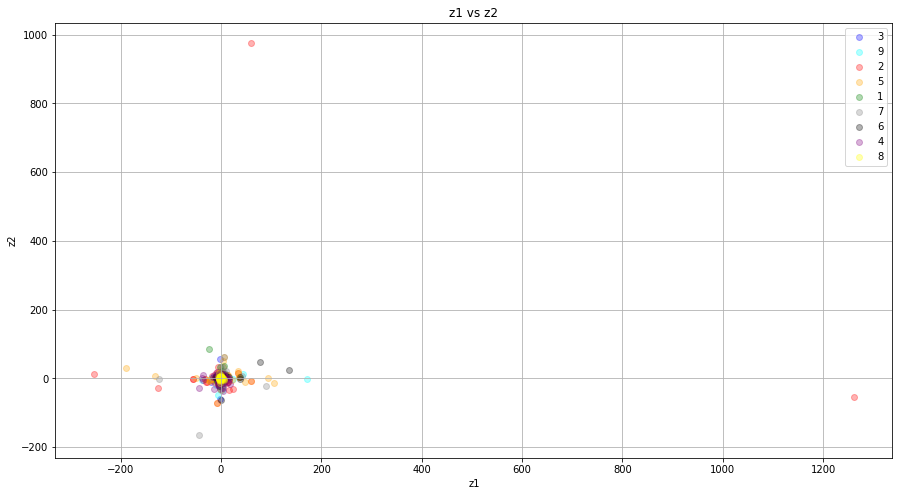

In [119]:
label_to_color = {
    '1': 'green',
    '2': 'red',
    '3': 'blue',
    '4': 'purple',
    '5': 'orange',
    '6': 'black',
    '7': 'gray',
    '8': 'yellow',
    '9': 'cyan'
}

plt.figure(figsize = (15, 8))
for label in principal_data['first_label'].unique():
  plt.scatter(
    principal_data[principal_data['first_label'] == label]['z1'],
    principal_data[principal_data['first_label'] == label]['z2'],
    alpha = 0.3,
    label = str(label),
    color = label_to_color[str(label)]
  )

plt.xlabel('z1')
plt.ylabel('z2')
plt.title('z1 vs z2')
plt.legend()
plt.grid()

# Используем метод kNN

## Найдем значение ошибки с использованием метода PCA

Разбиваем на тестовую и обучающую выборку

In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(principal_x, y, test_size = 0.3, random_state = 13)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

875 375


In [121]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [122]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test) 

0.5474285714285714 0.8186666666666667


In [123]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_predict))

[[10 16  3  0 14  1  0  2  1]
 [13 20  5  4 27  1  1  0  2]
 [15 22  3  1  7  0  2  0  0]
 [ 1  4  0  1  3  0  3  0  0]
 [20 33  6  0 30  6  4  0  0]
 [ 4 12  8  0  4  0  1  0  0]
 [ 9 11  0  0 11  0  3  0  0]
 [ 4  1  4  1  6  0  1  0  0]
 [ 2  5  2  1  1  2  0  0  1]]


Попробуем подобрать оптимальное количество ближайших соседей


In [124]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.7154285714285714 45


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [125]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test) 

0.68 0.76


## Сравним значение ошибки с оптимальным решением этой задачи без использования PCA

Используем оптимальное кол-во соседей из 1й лабы (45)

In [126]:
from sklearn.model_selection import train_test_split
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X, y, test_size = 0.3, random_state = 13)

knn = KNeighborsClassifier(n_neighbors = 45).fit(X_orig_train, y_orig_train)

err_train = np.mean(y_orig_train != knn.predict(X_orig_train))
err_test  = np.mean(y_orig_test  != knn.predict(X_orig_test))

print(err_train, err_test) 


0.7005714285714286 0.7413333333333333


 # Найдем оптимальное количество главных компонент

In [0]:
errs_test = []
errs_train = []
components_count = []
max_components = 100
nn_count = 45
step = 1
for component_count in range(2, max_components + 1, step):
  components_count.append(component_count)
  principal_components = decomposition.PCA(n_components=component_count).fit_transform(X)
  principal_x = pd.DataFrame(
      data = principal_components, 
      columns = ['z{}'.format(i + 1) for i in range(component_count)]
  )

  X_train, X_test, y_train, y_test = train_test_split(principal_x, y, test_size = 0.3, random_state = 13)

  knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

  err_train = np.mean(y_train != knn.predict(X_train))
  err_test  = np.mean(y_test  != knn.predict(X_test))

  errs_train.append(err_train)
  errs_test.append(err_test)

После чего отобразим на графике зависимость ошибки на тестовой и тренировочной выборке от количества главных компонент

Оптимальное кол-во компонент: 61. Минимальная ошибка на тестовой выборке: 0.696
Минимальная разница между ошибкой на тестовой и обучающей выборках при 41 компонентах


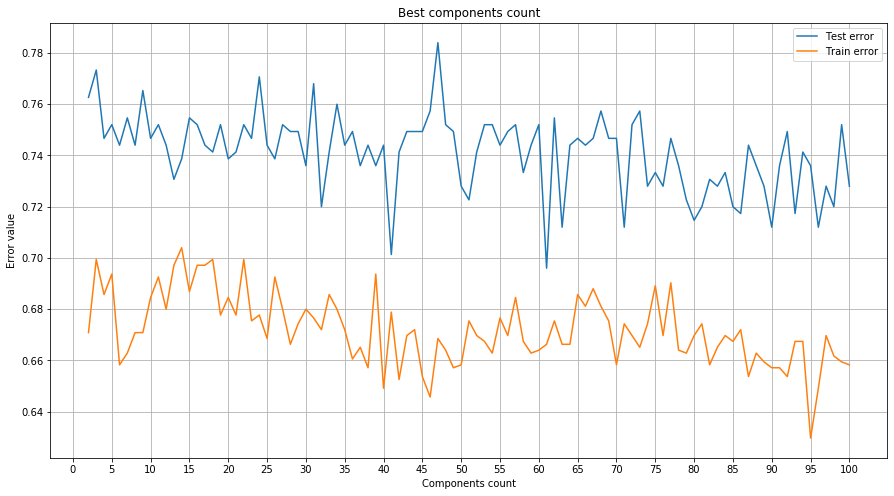

In [128]:
min_error = min(errs_test)
min_index = errs_test.index(min_error)
print('Оптимальное кол-во компонент: {}. Минимальная ошибка на тестовой выборке: {}'.format(components_count[min_index], min_error))

diffs = []
import math
for test_err, train_err in zip(errs_test, errs_train):
  diffs.append(math.fabs(test_err - train_err))

min_diff_index = diffs.index(min(diffs))
print('Минимальная разница между ошибкой на тестовой и обучающей выборках при {} компонентах'.format(components_count[min_diff_index]))

plt.figure(figsize = (15, 8))
plt.plot(
    components_count,
    errs_test,
    label='Test error'
)

plt.plot(
    components_count,
    errs_train,
    label='Train error',
)

plt.xlabel('Components count')
plt.ylabel('Error value')
plt.title('Best components count')
plt.xticks(np.arange(0, max_components + 1, 5))
plt.legend()
plt.grid()

Таким образом оптимальное количество главных компонент 61. Что *значительно* меньше чем исходное количество компонент. Если рассматривать именно уменьшение ошибки в целом. Если же рассматривать минимальную разницу между ошибкой на тестовой и обучающей выборкой, то она достигается при 41 компонентах

# Выводы

Поставленная задача может быть решена с точностью около 31% при использовании метода PCA с кол-вом компонент 61. Изначальная точность без использования метода составляет около 25%. Таким образом за счет использования метода PCA удалось добитсья увеличения точности на 6%